# Demo: Sigmoid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pylops
from pyctlops import FDCT2D

try:
    # Progress bars
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = lambda x: x
    print("Try out tqdm for progress bars!")

### Input data

In [2]:
inputfile = '../testdata/sigmoid.npz'

d = np.load(inputfile)
d = d['sigmoid']
nx, nt = d.shape
dx, dt = 8, 0.004
x, t = np.arange(nx) * dx, np.arange(nt) * dt

# slope estimation
slope = -pylops.utils.signalprocessing.slope_estimate(d.T, dt, dx, smooth=6)[0]

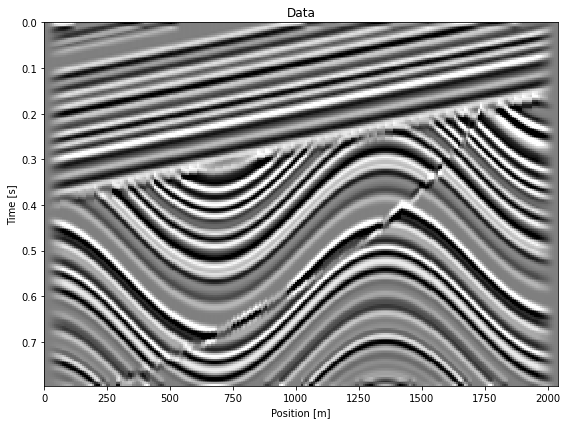

In [3]:
clip = 0.5 * np.max(np.abs(d))
opts = dict(aspect='auto', extent=(x[0], x[-1], t[-1], t[0]), vmin=-clip, vmax=clip, cmap='gray',
            interpolation='nearest')

fig, ax = plt.subplots(figsize=(8, 6), sharey=True, sharex=True)
ax.imshow(d.T, **opts)
ax.set(xlabel='Position [m]', ylabel='Time [s]', title='Data')
fig.tight_layout()

### Sparsifying Transforms
* Seislet
* Wavelet
* Curvelet

In [4]:
Sop = pylops.signalprocessing.Seislet(slope.T, sampling=(dx, dt))
Sop.shape

(51200, 51200)

In [5]:
Wop = pylops.signalprocessing.Seislet(np.zeros_like(slope.T), sampling=(dx, dt))
Wop.shape

(51200, 51200)

In [6]:
Cop = FDCT2D(d.shape)
Cop.shape

(387589, 51200)

In [7]:
def reconstruct(data, op, perc=0.1):
    """
    Convenience function to calculate reconstruction using top
    `perc` percent of coefficients of a given operator `op`.
    """
    y = op * data.ravel()
    denoise = np.zeros_like(y)
    
    # Order coefficients by strength
    strong_idx = np.argsort(-np.abs(y))
    strong = np.abs(y)[strong_idx]

    # Select only top `perc`% coefficients
    strong_idx = strong_idx[:int(np.rint(len(strong_idx) * perc))]
    denoise[strong_idx] = y[strong_idx]
    
    data_denoise = op.inverse(denoise).reshape(data.shape)
    return np.real(data_denoise), strong

In [8]:
# Reconstruct data with only 10% of the strongest coefficients in sparse domain
perc = 0.1
d_seis, seis_strong = reconstruct(d, Sop, perc=perc)
d_dwt, dwt_strong = reconstruct(d, Wop, perc=perc)
d_dct, dct_strong = reconstruct(d, Cop, perc=perc)

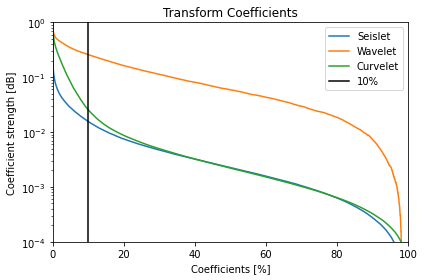

In [9]:
fig, ax = plt.subplots()
ax.semilogy(np.linspace(0, 100, len(seis_strong), endpoint=True),
        seis_strong / seis_strong[0], label='Seislet')
ax.semilogy(np.linspace(0, 100, len(dwt_strong), endpoint=True),
        dwt_strong / dwt_strong[0], label='Wavelet')
ax.semilogy(np.linspace(0, 100, len(dct_strong), endpoint=True),
        dct_strong / dct_strong[0], label='Curvelet')
ax.set(xlim=(0, 100), ylim=(1e-4, 1), xlabel="Coefficients [%]", ylabel="Coefficient strength [dB]",
       title="Transform Coefficients")
ax.axvline(100*perc, color='k', label=f'{100*perc:.0f}%')
ax.legend()
fig.tight_layout()

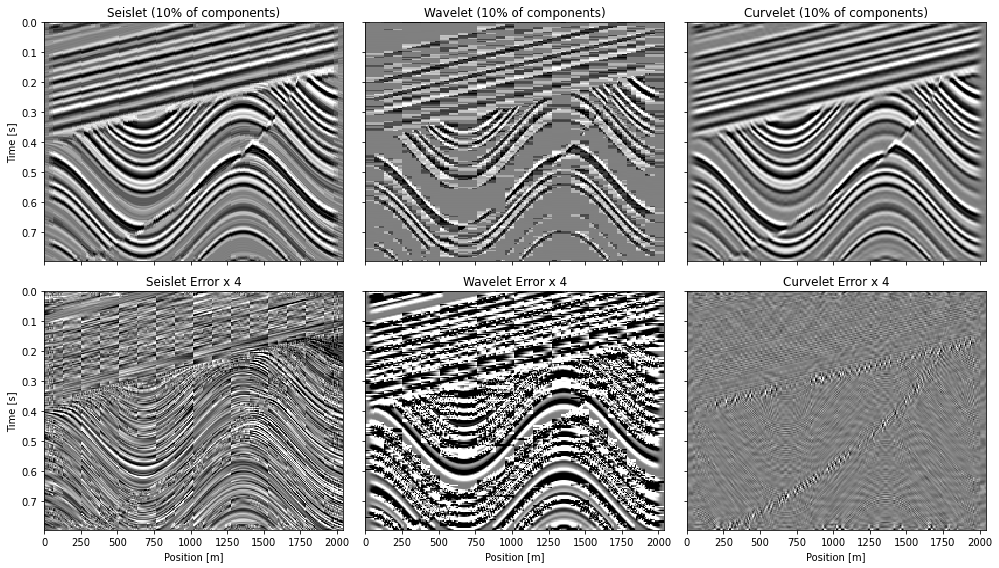

In [10]:
gain = 4
fig, ax = plt.subplots(2, 3, figsize=(14, 8), sharey=True, sharex=True)
for i, (d_trans, title) in enumerate(zip([d_seis, d_dwt, d_dct],
                                         ['Seislet', 'Wavelet', 'Curvelet'])):
    ax[0,i].imshow(d_trans.T, **opts)
    im = ax[1,i].imshow((d-d_trans).T, **opts)
    im.set_clim(vmin=-clip/gain, vmax=clip/gain)
    ax[0,i].set(title=f'{title} ({100*perc:.0f}% of components)')
    ax[1,i].set(title=f'{title} Error x {gain}', xlabel='Position [m]')
ax[0,0].set(ylabel='Time [s]')
ax[1,0].set(ylabel='Time [s]')
fig.tight_layout()

In [11]:
# Calculate error in reconstruction by number of coefficients used
error_seis = []
error_dwt = []
error_dct = []
for perc in tqdm(2**np.arange(7) / 100.):
    d_seis = reconstruct(d, Sop, perc=perc)[0]
    d_dwt = reconstruct(d, Wop, perc=perc)[0]
    d_dct = reconstruct(d, Cop, perc=perc)[0]
    error_seis.append(np.linalg.norm(d_seis - d))
    error_dwt.append(np.linalg.norm(d_dwt - d))
    error_dct.append(np.linalg.norm(d_dct - d))    

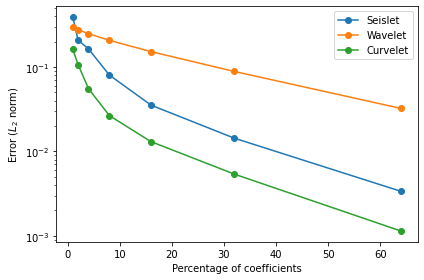

In [12]:
fig, ax = plt.subplots()
ax.semilogy(2**np.arange(7), error_seis, 'o-', label="Seislet")
ax.semilogy(2**np.arange(7), error_dwt, 'o-', label="Wavelet")
ax.semilogy(2**np.arange(7), error_dct, 'o-', label="Curvelet")
ax.set(xlabel="Percentage of coefficients", ylabel=r"Error ($L_2$ norm)")
ax.legend()
fig.tight_layout()